In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, tqdm
import numpy as np
import xarray as xr
import torch

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
#import mre_ai.mre_datasets

torch.cuda.is_available()

True

## Process images for a single patient

- load SITK images from NIFTI files
- perform filtering/inpainting on wave image
- register images wrt anatomical image
- load segmentation model
- perform image segmentation
- convert images to xarray Dataset

In [7]:
%autoreload
patient = mre_pinn.data.Patient(
    nifti_dir='/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI',
    patient_id='0006',
    sequences=[
        't1_pre_in', 't1_pre_out', 't1_pre_water', 't1_pre_fat', 't2', 'mre_raw', 'wave', 'mre'
    ],
    xarray_dir='../data/NAFLD_test/'
)
patient.load_images()
patient.metadata

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre.nii


size    spacing      origin       limit      center  \
sequence     dimension                                                        
t1_pre_in    0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_out   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_water 0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_fat   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t2           0           256   1.406300 -200.263000  158.343486  -20.959757   
             1           256   1.406300 -208.240997  150.365490  -28.937754   
             2            23  10.000000 -154.516006   65.483994  -44.516006   
mre_raw      0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4   1.000000    0.000000    3.000000    1.500000   
wave         0           512   1.000000    0.000000  511.000000  255.500000   
             1           512   1.000000    0.000000  511.000000  255.500000   
             2             4   1.000000    0.000000    3.000000    1.500000   
mre          0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4  11.000000   -1.056400   31.943600   15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          360.012787  
             1          360.012787  
             2          230.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2            4.000000  
wave         0          512.000000  
             1          512.000000  
             2            4.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000

In [9]:
%autoreload
patient.preprocess_images()

Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_in to mre_raw
ParameterObject (0x55e7fd274cb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 243971
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.6008 -16.5558 15.4436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.243 -196.198 -84.6065)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2

In [10]:
patient.metadata

size    spacing      origin       limit     center  \
sequence     dimension                                                       
t1_pre_in    0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t1_pre_out   0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t1_pre_water 0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t1_pre_fat   0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t2           0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2            23  10.000000  -94.556400  125.443600  15.443600   
mre_raw      0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
wave         0           512   0.703150 -207.255582  152.054055 -27.600763   
             1           512   0.703150 -196.210569  163.099068 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
mre          0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          360.012787  
             1          360.012787  
             2          230.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2           44.000000  
wave         0          360.012787  
             1          360.012787  
             2           44.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000

Converting t1_pre_in to xarray
Converting t1_pre_out to xarray
Converting t1_pre_water to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray


<IPython.core.display.Javascript object>


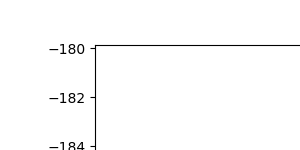

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [11]:
%autoreload
patient.view(compare=True)

In [ ]:
%autoreload
patient.save_xarrays()

In [ ]:
patient.load_xarrays()

## Process images for a patient cohort

In [ ]:
%ls /ocean/projects/asc170022p/shared/Data/MRE/*/NIFTI/ -d

In [ ]:
%cat /ocean/projects/asc170022p/shared/Data/MRE/gold.txt

In [ ]:
with open('/ocean/projects/asc170022p/shared/Data/MRE/gold.txt') as f:
    patient_ids = [line.split('.')[0].split('_')[1] for line in f]

len(patient_ids)

In [ ]:
%autoreload
cohort = mre_pinn.data.PatientCohort(
    nifti_dirs='/ocean/projects/asc170022p/shared/Data/MRE/*/NIFTI',
    patient_ids='{' + ','.join(patient_ids) + '}',
    xarray_dir='../data/NAFLD/'
)
len(cohort)

In [ ]:
%%time
cohort.load_images()

In [ ]:
%%time
m = cohort.metadata
m

In [ ]:
(m.reset_index().groupby(['patient_id', 'sequence']).dimension.count() == 3) \
    .reset_index().groupby(['patient_id']).dimension.all().all()

In [ ]:
%%time
cohort.create_xarrays()

In [ ]:
cohort[1].view(compare=True)

In [2]:
256 * 256

65536

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/MRE-PINN/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


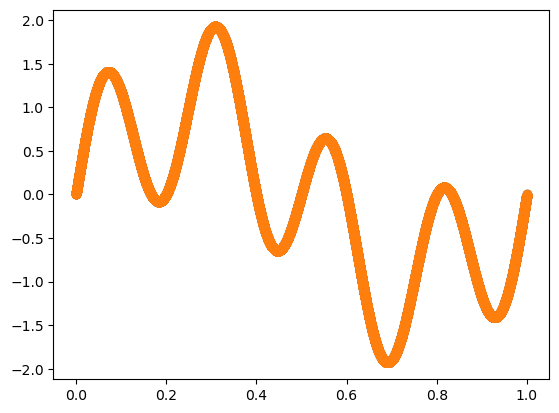

In [1]:
import numpy as np
import matplotlib.pyplot as plt
nax = np.newaxis

# input function
n_x = 1024
x = np.linspace(0, 1, n_x)
a = np.sin(2 * np.pi * x) + np.sin(8 * np.pi * x)

fig, ax = plt.subplots()
ax.scatter(x, a)

# Fourier transform
n_f = 128
f = np.arange(n_f)
norm = np.sqrt(n)
DFT = 1 / norm * np.exp(-2*np.pi*1j*f[:,nax]*x[nax,:]).T
Y = DFT @ y

# inverse Fourier transform
IDFT = 1 / norm * np.exp(2*np.pi*1j*x[:,nax]*f[nax,:]).T
yp = IDFT @ Y

# reconstructed signal
ax.scatter(x, yp)